# 🚀 Parte 2: Caso Segmentación de Clientes (Clustering)

**🎯 Resumen: Proyecto de Segmentación de Clientes**

El objetivo es utilizar técnicas de Machine Learning no supervisado para ayudar a la empresa RiseData a entender y perfilar a sus deportistas individuales.

1. El Problema de Negocio: Clasificar los deportistas que no pertenecen a grandes equipos en grupos homogéneos (segmentos). 
- Esto permitirá a RiseData:
    - Desarrollar políticas de marketing diferenciadas (personalizadas).
    - Fidelizar a los clientes.
    - Diseñar estrategias para mover a los clientes hacia segmentos más rentables.

2. Metodología: Clustering K-Means
- Dado que no disponemos de etiquetas previas sobre el "perfil ideal" de cada deportista (es un problema de descubrimiento)
- Este algoritmo agrupa los clientes según la similitud de sus características clave: Edad, Ingresos, y Puntuación (Score).

### ✅ Ejercicio 1: Carga, exploración y visualización inicial de los datos

**🛠️ Carga de librerías y dataset**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans

**🛠️ Exploración**

In [2]:
df_clientes = pd.read_csv("D:/IMMUNE/7. Asignatura 7 Aprendizaje automático/Case to be solved/Clientes.csv", sep=';')
display(df_clientes.head())
print(df_clientes.info())
print(df_clientes.describe(include='all').T)

,ID,Sexo,Edad,Ingresos,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        200 non-null    int64 
 1   Sexo      200 non-null    object
 2   Edad      200 non-null    int64 
 3   Ingresos  200 non-null    int64 
 4   Score     200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
          count unique     top freq   mean        std   min    25%    50%  \
ID        200.0    NaN     NaN  NaN  100.5  57.879185   1.0  50.75  100.5   
Sexo        200      2  Female  112    NaN        NaN   NaN    NaN    NaN   
Edad      200.0    NaN     NaN  NaN  38.85  13.969007  18.0  28.75   36.0   
Ingresos  200.0    NaN     NaN  NaN  60.56  26.264721  15.0   41.5   61.5   
Score     200.0    NaN     NaN  NaN   50.2  25.823522   1.0  34.75   50.0   

             75%    max  
ID        150.25  200.0  
Sexo         NaN    NaN  
Edad        49.0   70.0  
Ingresos

**Datos Faltantes (Count):** 
- Todas las variables tienen un count de 200
- No hay valores nulos (NaN) en ninguna de las columnas numéricas.

**Variables para Clustering:**
- ID: Es una clave única. Eliminar antes del clustering.
- Edad: De 18 a 70 años (media de 38.8)
- Ingresos: De 15K a 137K - en miles (Media de 60.57K y std importante de 26.24)
- Score: De 1 a 99 con media de 50. Parece ya normalizada y escalada entre 1 y 100 (revisarse)

**🛠️ Variable categórica**

In [3]:
df_clientes['Sexo'].value_counts()

Sexo
Female    112
Male       88
Name: count, dtype: int64

**Variables Categóricas Faltantes:**
- La columna "Sexo" no aparece en la tabla descriptiva. 
- Es una variable categórica (Object/String)
- Revisar si necesita ser codificada o si se debe incluir en el clustering.

**🛠️ Código para Limpieza de Datos (Lower, Strip, Replace)**

In [8]:
def clean_col_name (col_name):
    return col_name.strip().lower().replace(" ","_")
df_clientes.columns = [clean_col_name (col) for col in df_clientes.columns]

df_clientes['sexo'] = df_clientes['sexo'].astype(str).str.strip().str.lower()

print(df_clientes.columns.tolist())

['id', 'sexo', 'edad', 'ingresos', 'score']


-----------------------------------------------------------------------------------------------------------------------------------

📊 **Visualizaciones iniciales de datos crudos**

-----------------------------------------------------------------------------------------------------------------------------------

- Para un caso de clustering sin una variable objetivo:
    - Se hace un diagramas de dispersión (scatter plots) para ver si hay grupos obvios.

**Datos Crudos con 4 Dimensiones**

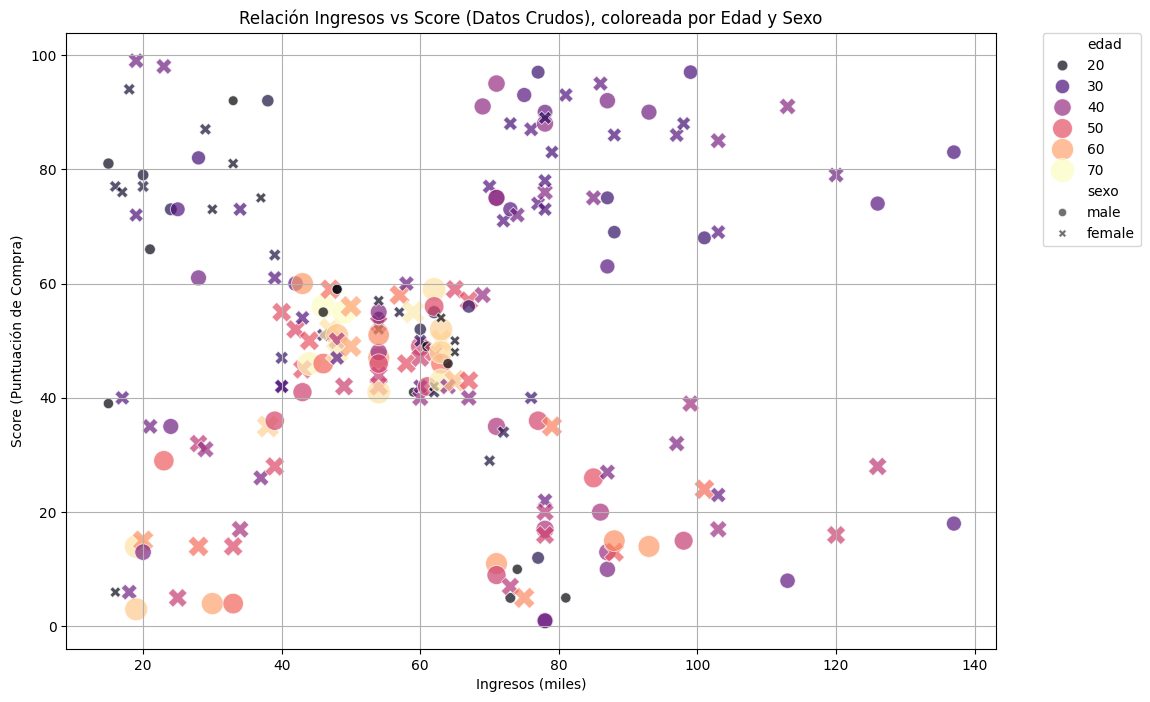

In [10]:
X_visual_sexo = df_clientes[['ingresos', 'score', 'edad', 'sexo']].copy()

plt.figure(figsize=(12, 8))

# Usamos 'edad' para el color (hue) y 'sexo' para el estilo del marcador (style)
sns.scatterplot(
    x='ingresos', 
    y='score', 
    hue='edad', 
    style='sexo',       # Utiliza la variable categórica 'sexo' para el tipo de marcador
    data=X_visual_sexo, 
    palette='magma', 
    size='edad',
    sizes=(50, 300),
    alpha=0.7
) 

plt.title('Relación Ingresos vs Score (Datos Crudos), coloreada por Edad y Sexo')
plt.xlabel('Ingresos (miles)')
plt.ylabel('Score (Puntuación de Compra)')
plt.grid(True)
# Mover leyenda fuera del plot para evitar superposición
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

| ID Visual | Rango Ingresos / Score | Perfil de Gasto Valor | Edad (Perfilado) | Conclusiones Clave para RiseData |
|:---       |:---                    |:---                   |:---              |:---                              |
|1 | Medio / Medio | Clientes Típicos (Central): Grupo más grande y estable. | Media a Mayor (40s - 60s) | Estrategia de Retención y Lealtad. Deben ser el objetivo principal para migrar a VIP.|
|2 | Alto / Bajo (Inferior - derecha) | "Clientes Desaprovechados: Alto poder adquisitivo, pero no gastan en la compañía. | ",Media (40s - 50s) | Prioridad en Investigación de Mercados para entender por qué gastan en la competencia. Gran potencial de captura de gasto. |
| 3 | Bajo / Alto (Superior - izquierda) | "Alto Valor, Bajo Ingreso: Clientes muy reactivos y de alto gasto relativo." | Muy Joven (20s - 30s) | Confirma que la estrategia de Promociones y Descuentos es vital para mantener su alta actividad. Es el CLV futuro de la compañía.|
| 4 | Alto / Alto | Clientes VIP (Superior Derecho): Los más rentables y valiosos. | Intermedia (30s - 40s) | Aplicar estrategias Premium y trato exclusivo. Tienen el mayor Valor de Vida del Cliente (CLV) por su capacidad de gasto y edad.|
| 5 | Bajo / Bajo | "Bajo Valor, Bajo Ingreso: Mínimo poder adquisitivo y mínimo gasto." | Media a Mayor (40s+) | Minimizar el gasto en Marketing en este grupo. Bajo potencial de crecimiento.|

**Datos Crudos con 3 Dimensiones**

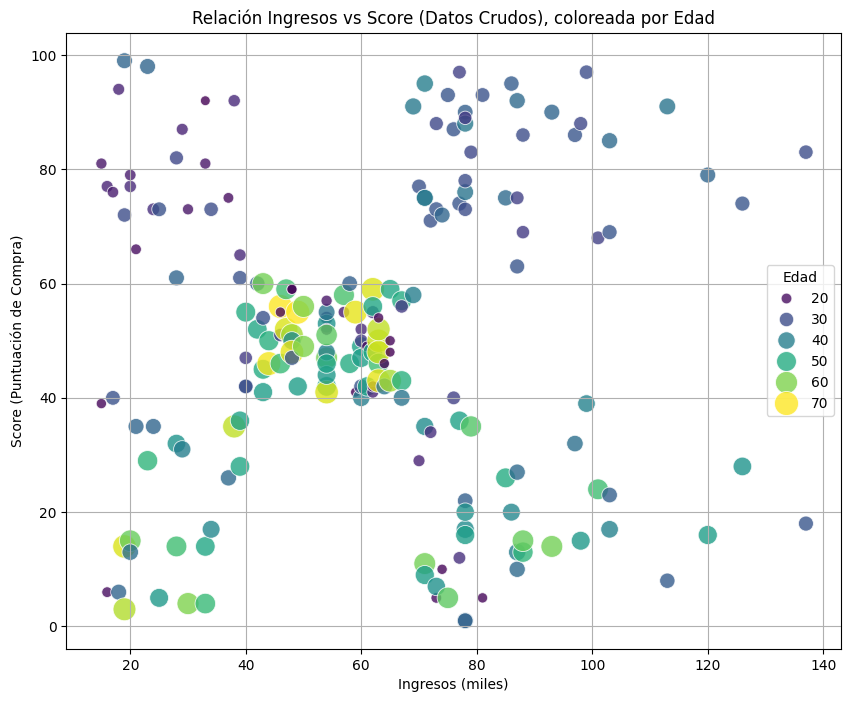

In [11]:
X_visual_edad = df_clientes[['ingresos', 'score', 'edad']].copy()

plt.figure(figsize=(10, 8))

# Usamos 'edad' para el color (hue).
sns.scatterplot(
    x='ingresos', 
    y='score', 
    hue='edad', 
    data=X_visual_edad, 
    palette='viridis', # Un buen esquema de color continuo para la edad
    size='edad',       # El tamaño del punto también varía con la edad
    sizes=(50, 300),   
    alpha=0.8
) 

plt.title('Relación Ingresos vs Score (Datos Crudos), coloreada por Edad')
plt.xlabel('Ingresos (miles)')
plt.ylabel('Score (Puntuación de Compra)')
plt.grid(True)
plt.legend(title='Edad')
plt.show()

| Cluster (Referencia Visual) | Rango Ingresos / Score | Perfil de Edad Dominante (Color) | Implicación Estratégica Clave para RiseData |
|:---                         |:---                    |:---                              |:---                                         |  
| VIP (Superior Derecho)| Alto / Alto | Intermedia (30s y 40s) y Diversa | La edad joven/intermedia asegura un alto Valor de Vida del Cliente (CLV). Las estrategias Premium deben ser generacionales.|
| "Alto Valor, Bajo Ingreso (Superior Izquierdo)" |Bajo / Alto | Muy Joven (20s - 30s) (Púrpura Oscuro)  | El gasto es impulsado por la juventud (probablemente sensibles a las tendencias y precios). La estrategia de Promociones es vital.|
| Desaprovechados (Inferior Derecho) | Alto / Bajo | Mayor (50s - 70s) (Verde/Amarillo) | La edad más avanzada sugiere alta fidelidad a marcas de la competencia. Necesaria Investigación de Mercados especializada en este segmento.|
| Típicos (Central) | Medio / Medio | Media (40s - 60s) (Azul/Turquesa) | Grupo estable que requiere marketing enfocado en la Retención y el servicio. Son el objetivo primario para ascender al grupo VIP.|
| "Bajo Valor, Bajo Ingreso (Inferior Izquierdo)" | Bajo / Bajo | Mixta (con presencia de jóvenes y mayores) | Baja prioridad de marketing. La presencia de mayores (70s) indica bajo poder adquisitivo en la jubilación. Minimizar el gasto.|

**Datos Crudos con 2 Dimensiones**

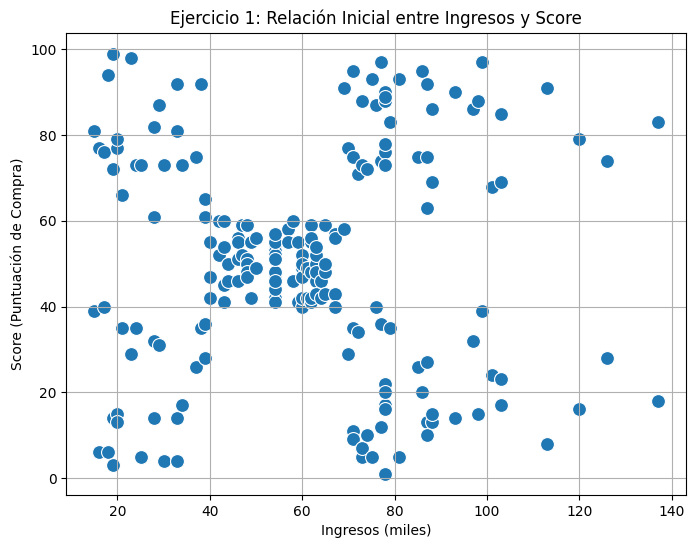


--- Vista de Features Limpias ---
   ingresos  score
0        15     39
1        15     81
2        16      6
3        16     77
4        17     40


In [12]:
# Columnas clave para la segmentación visual inicial
X_visual = df_clientes[['ingresos', 'score']].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='ingresos', y='score', data=X_visual, s=100) # s=100 para un buen tamaño de punto

plt.title('Ejercicio 1: Relación Inicial entre Ingresos y Score')
plt.xlabel('Ingresos (miles)')
plt.ylabel('Score (Puntuación de Compra)')
plt.grid(True)
plt.show()

# verificar
print("\n--- Vista de Features Limpias ---")
print(X_visual.head())

**📋 Segmentación de Clientes: Análisis del Gráfico de Dispersión**

El gráfico muestra cinco segmentos (clusters) claros que sugieren la aplicación de un Análisis de Clustering (como K-Means) para segmentación de mercado.

| ID | Nombre del Cluster | Rango de Ingresos (Eje X) | Rango de Score (Eje Y) | Perfil del Cliente | Implicaciones Estratégicas Clave |
| :---: | :--- | :--- | :--- | :--- | :--- |
| **1** | **Clientes Típicos (Central)** | Medios (Aprox. 40 - 70 miles) | Medios (Aprox. 40 - 60) | El grupo más grande y estable. Clientes "de la media" con ingresos y gastos promedio. | Estrategias de **Retención y Lealtad**. Intentar moverlos hacia el cluster Superior Derecho mediante ofertas específicas. |
| **2** | **Alto Valor, Bajo Ingreso** | **Bajos** (Menos de 40 miles) | **Alto** (Mayor de 80) | Clientes que **gastan mucho**, pero tienen bajos ingresos. Son altamente reactivos. | Enfocar en **Promociones y Descuentos** para mantener su alto nivel de compra. Considerar el riesgo crediticio si es relevante. |
| **3** | **Bajo Valor, Bajo Ingreso** | Bajos (Menos de 40 miles) | **Bajo** (Menos de 20) | Mínimo poder adquisitivo y mínimo gasto. | **Minimizar el gasto en Marketing** para este grupo. Son de bajo valor potencial. |
| **4** | **Clientes VIP (Superior Derecho)** | **Altos** (Mayor de 70 miles) | **Alto** (Mayor de 80) | **El grupo más valioso (Alto Ingreso + Alto Gasto).** Clientes ideales y rentables. | Aplicar estrategias **Premium** y de trato exclusivo (CRM). Prioridad absoluta para la **Maximización del Valor de Vida del Cliente (CLV)**. |
| **5** | **Desaprovechados (Inferior Derecho)** | Altos (Mayor de 70 miles) | **Bajo** (Menos de 20) | Tienen altos ingresos, pero **no gastan aquí**. El poder adquisitivo existe, pero se gasta en la competencia. | **Investigación de Mercados** para entender sus necesidades no cubiertas. Campañas dirigidas a **Capturar su Gasto** que va a otros lados. |

- **Observación Adicional** : La falta de una correlación lineal clara y la presencia de agrupaciones definidas sugieren que los datos son ideales para la **Segmentación de Clientes**.

- **Nota resumen**: Entendemos que hay 5 grupos principales y 8 outliers de altos ingresos.

### 🧭 Desglose del Ejercicio 2 (Análisis Exploratorio de Datos - EDA)

Preparar matemáticamente las features para el algoritmo K-Means ya que es sensible a los outliers y a las diferencias de escala.

| Paso | Acción | Propósito / Justificación | 
|:---      |:---        |:---               |  
| Paso 1 | Tratamiento de Outliers (Capping) | Mitigar el impacto de los 8 clientes de Ingresos muy altos (115K-140K) en el cálculo de las distancias del clustering. | 
| Paso 2 | Escalado de Datos (StandardScaler) | Asegurar que todas las variables (edad, ingresos, score) tengan la misma importancia en el cálculo de distancias, transformándolas a media $0$ y desviación estándar $1$. |
| Paso 3 | Verificación del Escalado | Confirmar con la tabla de estadísticas descriptivas (.describe().T) que la media y la desviación estándar de la matriz final son correctas. |

_________________________________________________________________________________________________________________________________________________________________________________________________
**🔬 Síntesis Comparativa de los 5 Clusters (2D, 3D y 4D)**

| ID  | Nombre Propuesto (Basado en 2D) | Ingreso / Score (2D: Fuerza Motriz) | Edad (3D: Perfil Clave) | Sexo (4D: Patrón) | Estrategia de Negocio Determinante |
|:--- |:---                             |:---                                 |:---                     |:---                |:---                               |
|1 | Clientes VIP | Alto / Alto (Ideal) | Intermedia (30s-40s) y diversa | Uniforme/Mixto | Maximización del CLV (Estrategias Premium)|
|2 | "Alto Valor, Bajo Ingreso"| Bajo / Alto (Reactivo) | Muy Joven (20s-30s) | Mixto | Fidelización basada en Precios y Promociones|
|3 | Desaprovechados | Alto / Bajo (Fuga de Gasto) | Mayor (50s-70s) | Uniforme/Mixto | Investigación de Mercados para recuperar su gasto de la competencia.|
|4 | Clientes Típicos | Medio / Medio (Estable) | Media (40s-60s) | Uniforme/Mixto | Estrategias de Retención y Migración a grupos VIP.|
|5 | "Bajo Valor | Bajo Ingreso",Bajo / Bajo (Mínimo) | Mixta (Baja prioridad) | Uniforme/Mixto | Minimizar el Gasto en Marketing (bajo potencial).|

**Conclusión de la Comparación**
- La división en 5 clusters es extremadamente robusta
- Es el binomio Ingresos/Score la fuerza impulsora principal (2D).
- La Edad (3D) resultó ser el perfilador demográfico más determinante (Distingue cliente VIP joven/intermedio de cliente Desaprovechado/Mayor)
- El Sexo (4D) se distribuye de manera uniforme y no es un factor clave de diferenciación en este dataset (inclinado un poco más hacia la mujer).

** 🛠️ PASO 1: CAPPING (Tratamiento de Outliers)**

In [13]:
# Se utiliza el cuantil 99% como límite superior.
ingresos_umbral = df_clientes['ingresos'].quantile(0.99)
df_clientes['ingresos'] = np.where(
    df_clientes['ingresos'] > ingresos_umbral, 
    ingresos_umbral, 
    df_clientes['ingresos']
)
print(f"✅ Capping aplicado. El valor máximo de Ingresos se limitó a: {df_clientes['ingresos'].max():.2f}")

✅ Capping aplicado. El valor máximo de Ingresos se limitó a: 126.11


** 🛠️ PASO 2: ESCALADO DE DATOS (StandardScaler)**

**Inclusión de la Variable 'Sexo' en Scaler y K-Means**
- No es necesario y mejor evitar el One-Hot Encoding para este caso.
- En las visualizaciones multidimensionales (el gráfico 4D) la variable sexo (Male/Female) no es un factor primario de diferenciación de los clusters. 
- La estructura de los 5 grupos es impulsada por:
    - Ingresos y Score (la fuerza principal).
    - Edad (el factor de perfilado secundario).

In [14]:
# StandardScaler
COLUMNAS_CLUSTERING = ['edad', 'ingresos', 'score']
X = df_clientes[COLUMNAS_CLUSTERING].copy()

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

In [15]:
print("\n--- Verificación del Escalado (describe().T) ---")
print(X_scaled.describe().T)


--- Verificación del Escalado (describe().T) ---
          count          mean       std       min       25%       50%  \
edad      200.0 -1.021405e-16  1.002509 -1.496335 -0.724844 -0.204535   
ingresos  200.0  1.421085e-16  1.002509 -1.754736 -0.731647  0.040495   
score     200.0 -1.465494e-16  1.002509 -1.910021 -0.599793 -0.007764   

               75%       max  
edad      0.728432  2.235532  
ingresos  0.677512  2.534900  
score     0.885132  1.894492  


**🛠️ Interpretación:**

- Media (mean): Todos los valores son prácticamente cero (e-16) (objetivo del StandardScaler).
- Desviación Estándar (std): Todos los valores son prácticamente uno (1.0025) (objetivo del StandardScaler).

**Conclusión**:
- Las variables edad, ingresos y score están perfectamente estandarizadas para que:
    - K-Means trate a cada una con la misma importancia
    - Y los outliers extremos de ingresos fueron controlados mediante el Capping.

### 🧭 Ejercicio 3: Identificación del Número de Clusters

**Método del Codo (Elbow Method)**
- Para calcular la métrica WCSS (Suma de Cuadrados Intra-Cluster) para diferentes valores de $K$.
- Se busca el punto de inflexión para confirmar tu análisis visual de $K=5$.

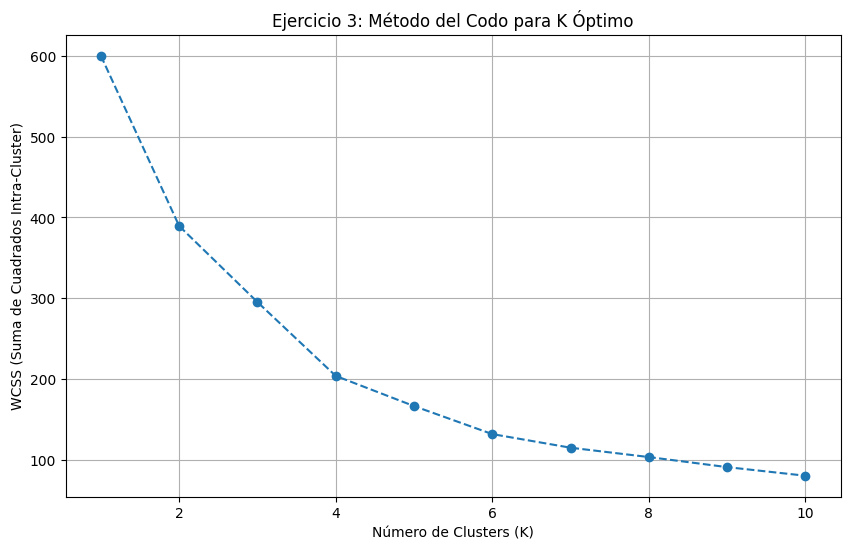

In [16]:
wcss = []
# Probamos desde K=1 hasta K=10 para ver la curva completa
for i in range(1, 11):
    # n_init=10 asegura que K-Means corra 10 veces para encontrar la mejor inicialización
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    
    # Ajustar el modelo a nuestros datos escalados (X_scaled)
    kmeans.fit(X_scaled)
    
    # inertia_ es el atributo que guarda el valor de WCSS
    wcss.append(kmeans.inertia_)

# 2. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Ejercicio 3: Método del Codo para K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Cluster)')
plt.grid(True)
plt.show()

**📉 Interpretación Final del Método del Codo (Ejercicio 3)Caída Inicial:**

- Caída muy abrupta en la WCSS al pasar de $K=1$ a $K=2$ y de $K=2$ a $K=3$
    - Indica que los primeros clusters son muy beneficiosos para reducir la varianza interna.

- Punto de Inflexión (Codo):
    - El punto donde la curva comienza a aplanarse significativamente, asemejando un "codo" (valor óptimo de $K$.)
        - *Al examinar la curva el punto de mayor inflexión y más claro se produce en $K=5$.*
        - *La reducción en la WCSS al pasar de $K=5$ a $K=6$ (y en adelante) es mucho menos pronunciada que en los pasos anteriores.*

- Validación Cruzada: 
    - Resultado de $K=5$ valida la identificación visual de 5 grupos en el scatter plot 2D y que se mantuvo en 3D y 4D.
    
**Conclusión: El número óptimo de clusters a utilizar para el algoritmo K-Means es $\mathbf{K=5}$.**

### ✅ **Ejecución de K-Means**

In [18]:
# K-Means con K=5
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
# Ajustar modelo a datos estandarizados (X_scaled)
kmeans.fit(X_scaled) 

# Etiquetas de cluster al DF original (df_clientes)
df_clientes['cluster_label'] = kmeans.labels_

# Distribución de clusters
print("--- Distribución de Clientes por Cluster ---")
print(df_clientes['cluster_label'].value_counts().sort_index())

--- Distribución de Clientes por Cluster ---
cluster_label
0    20
1    54
2    39
3    40
4    47
Name: count, dtype: int64


**Observación:**
- El Cluster 1 es el más grande (54 clientes)
- Seguido por el 4 y el 3. 
- El Cluster 0 es el más pequeño - 20 clientes (típico para un grupo extremo: VIP o Desaprovechados.)

**Generar el Perfil Cuantitativo (Medias y Sexo)**

In [19]:
# Media por Cluster - DF original para valores reales (Ingresos en miles, Edad en años)
perfil_numerico = df_clientes.groupby('cluster_label')[['edad', 'ingresos', 'score']].mean()
print("\n--- A. Perfil Numérico (Medias por Cluster) ---")
print(perfil_numerico.round(2))

# Variable categórica (Sexo por Cluster - perfilar género de cada grupo)
perfil_sexo = pd.crosstab(df_clientes['cluster_label'], df_clientes['sexo'], normalize='index') * 100
print("\n--- B. Perfil de Sexo (Porcentaje por Cluster) ---")
print(perfil_sexo.round(2))


--- A. Perfil Numérico (Medias por Cluster) ---
                edad  ingresos  score
cluster_label                        
0              46.25     26.75  18.35
1              25.19     41.09  62.24
2              39.87     85.82  19.36
3              32.88     85.83  81.53
4              55.64     54.38  48.85

--- B. Perfil de Sexo (Porcentaje por Cluster) ---
sexo           female   male
cluster_label               
0               60.00  40.00
1               59.26  40.74
2               48.72  51.28
3               55.00  45.00
4               57.45  42.55


### 🎯 Calificación y nombramiento final para RiseData

| ID | Perfil Principal (Ingresos/Score) | Edad Media | Sexo Mayoritario | Nombre Comercial (Calificación) | Estrategia de Marketing (RiseData) |
| :---: | :---: | :---: | :---: | :--- | :--- |
| **3** | **Alto / Alto** (Ingreso: 85.83, Score: 81.53) | 32.88 | Femenino (55%) | **Clientes VIP (High CLV)** | **Máxima Prioridad.** Programas **Premium**, trato exclusivo, y enfoque en la retención para maximizar el Valor de Vida del Cliente (CLV). |
| **2** | **Alto / Bajo** (Ingreso: 85.82, Score: 19.36) | 39.87 | **Masculino (51%)** | **Clientes Desaprovechados** | **Alto Potencial.** Urge **Investigación de Mercados** para entender el freno y campañas agresivas de adquisición. |
| **1** | **Bajo / Alto** (Ingreso: 41.09, Score: 62.24) | 25.19 | Femenino (59%) | **Alto Valor Relativo (Jóvenes Reactivos)** | **Alto Retorno.** El grupo **más joven**. Estrategias de **Promociones y Descuentos** para mantener su alta frecuencia de compra. |
| **4** | **Medio / Medio** (Ingreso: 54.38, Score: 48.85) | 55.64 | Femenino (57%) | **Clientes Típicos (Estables y Mayores)** | **Retención.** El grupo más **mayor**. Estrategias de **Lealtad y Servicios** (no promociones), buscar migrar a VIP. |
| **0** | **Bajo / Bajo** (Ingreso: 26.75, Score: 18.35) | 46.25 | Femenino (60%) | **Bajo Valor/Bajo Ingreso** | **Baja Prioridad.** Mínimo poder adquisitivo y gasto. **Minimizar la inversión en Marketing**. |

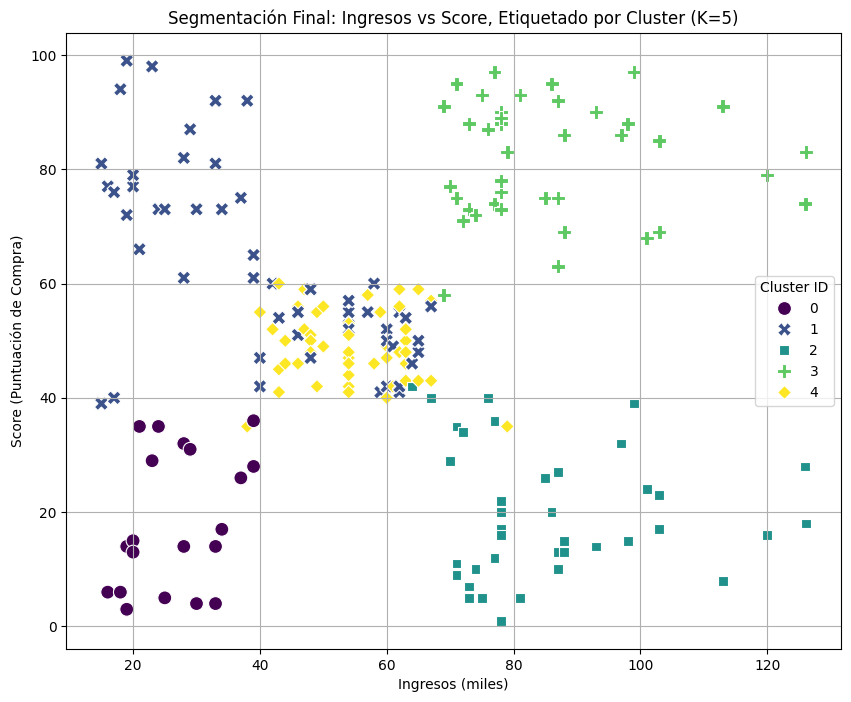

In [20]:
plt.figure(figsize=(10, 8))
# Usamos el DF df_clientes que ya tiene la etiqueta 'cluster_label'
sns.scatterplot(
    x='ingresos', 
    y='score', 
    hue='cluster_label', # Colorear por la etiqueta de cluster (0 a 4)
    data=df_clientes, 
    palette='viridis',   
    s=100,               
    style='cluster_label'
) 

plt.title('Segmentación Final: Ingresos vs Score, Etiquetado por Cluster (K=5)')
plt.xlabel('Ingresos (miles)')
plt.ylabel('Score (Puntuación de Compra)')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

### 🚀 Conclusiones Finales

- Existencia de cinco (5) segmentos de clientes únicos y estratégicamente diferenciados.


- Impulsado primariamente por:
    - Relación Ingresos vs. Score (Gasto/Actividad)
    - Factor Edad como descriptor demográfico más útil para el perfilado.

**Hallazgos Clave de la Segmentación (K=5)**

Alto Valor/Alto Riesgo Etario: Segmentación distingue entre los grupos de Alto Gasto (Alto Score):
- Clientes VIP (ID 3): 
    - Segmento de mayor valor, media de 33 años, alto Ingreso y alto Score (Garantiza un alto (CLV) a largo plazo.)
    - Jóvenes Reactivos (ID 1): Grupo más joven, media de 25 años, bajos ingresos pero con alto score (extrema sensibilidad a las ofertas)


Riesgo en Clientes Desaprovechados (ID 2): 
- Segmento de Altos Ingresos que no gasta en RiseData (Clientes Desaprovechados)
    - Media de 40 años, profesionales con alto poder adquisitivo y fidelizados a la competencia.

- Robustez del Modelo: 
    - Las 5 agrupaciones visuales en raw data (Ingresos vs Score) fueron replicadas con precisión por el algoritmo K-Means. 
        - La visualización final (Ingresos vs Score coloreada por etiqueta) confirma la separación clara y lógica entre los segmentos.

### 🚀 Recomendaciones Estratégicas

| Cluster (ID) | Nombre Comercial | Objetivo Estratégico | Acción de Marketing / Venta |
| :---: | :--- | :--- | :--- |
| **3** | **Clientes VIP** | **Maximizar el CLV.** | Programas de **Exclusividad/Premium** y lanzamientos tempranos (para aprovechar su fidelidad y alto poder de gasto). |
| **1** | **Alto Valor Relativo** | **Mantener la Frecuencia.** | Campañas de **Promociones** altamente dirigidas (ej. ofertas por tiempo limitado) para satisfacer su sensibilidad al precio y alta actividad. |
| **2** | **Clientes Desaprovechados** | **Adquisición Agresiva.** | **Invertir en Investigación de Mercados** (encuestas) para identificar qué les ofrece la competencia y diseñar ofertas que rompan su fidelidad actual. |
| **4** | **Clientes Típicos** | **Retención y Migración.** | **Marketing de Lealtad y Servicio** (menos promocional) para asegurar su permanencia y moverlos a segmentos de mayor rentabilidad (VIP). |
| **0** | **Bajo Valor/Bajo Ingreso** | **Optimizar el Gasto.** | Mínima inversión; enfocar el gasto de marketing en segmentos de mayor retorno. |